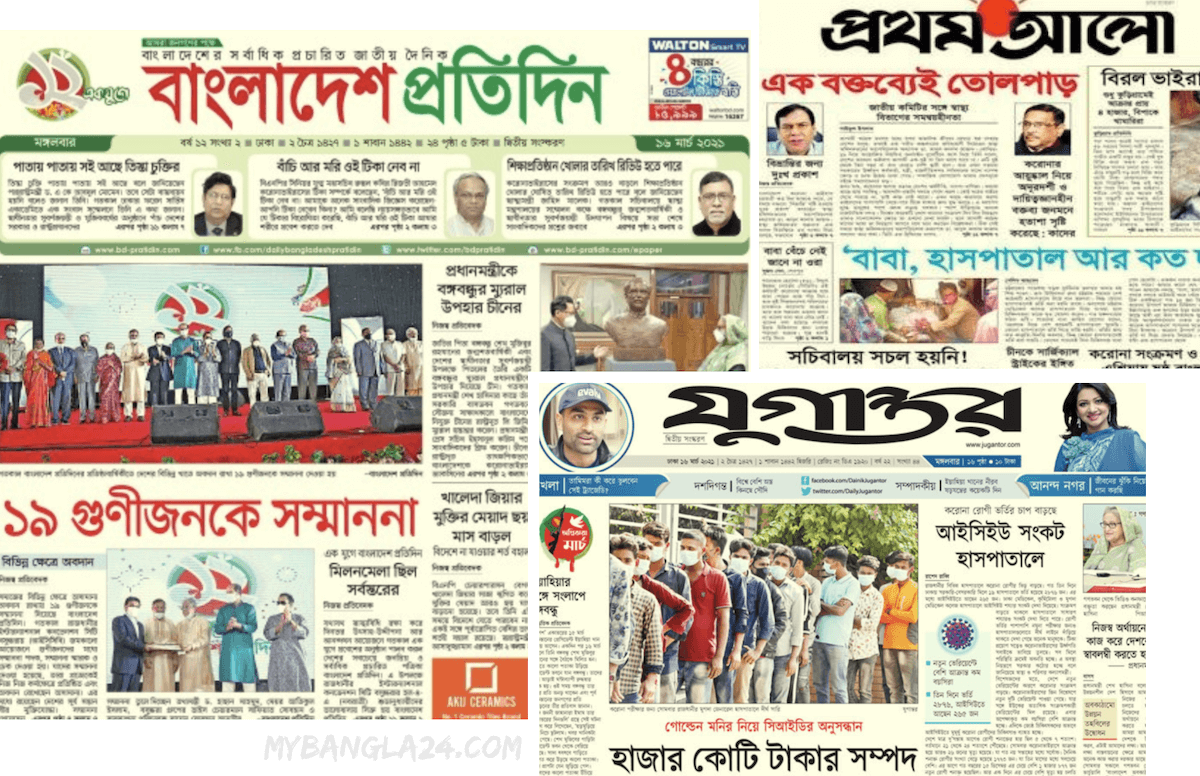

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Load Data

In [3]:
import json
with open(file='../input/bangla-newspaper-dataset/data/data.json', encoding='utf-8') as file:
    data=json.load(file)

In [4]:
len(data)

In [5]:
# Show indivudial data
data[0:3]

In [6]:
data[5]['content']


## Sample tokenization of dataset

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 100)  #maximum word limit 100
tokenizer.fit_on_texts(data[1]['content']) # fit sentence

In [8]:
word_index = tokenizer.word_index
print(word_index) #word index of tokenized sentence
tokenizer.word_counts #word count of tokenized sentence

In [9]:
# Present tokenization config
tokenizer.get_config()

## List of category

In [10]:
all_category=[]
for i in range(len(data)):
    cat=data[i]['category']
#     print(cat)
    all_category.append(cat)

# Total unique category
unique_cat=np.unique(np.array(all_category))
print(len(unique_cat))

**Total Category**

In [11]:
from collections import Counter
Counter(all_category)

**Count total unique category**

In [12]:
category_count=[]
for category in unique_cat:
    x=all_category.count(category) # Count
    category_count.append((category,x)) #make list

# Sort all unique category
category_count.sort()
category_count

In [13]:
new_cat=[]
for i in category_count:
    if i[1] > 6000:
        new_cat.append(i[0])
new_cat

> **Make new category list Where category count is greater than 6000.**
Here is only 11 category from 32 ctegory

## Convert Feature and Target from main dataset

In [14]:
feature=[]
target=[]

for p in data:
    if p['category'] in new_cat:
        feature.append(p['content'])
        target.append(p['category'])

In [15]:
print(len(target))
print(len(feature))

In [16]:
len(data)- len(target)

15085 data remove after analysis the dataset

In [17]:
# Check dataset
print("Category: --",target[100])
print("Content: --",feature[100])

In [18]:
len(feature[1])

## label Encoding

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

en_target=le.fit_transform(target)


In [20]:
set(en_target)

## Split data
Make train and test dataset

In [21]:
len(en_target)

In [22]:
# dataset len is 422863. So 400000 data for train other will test
train_size= 400000

# train
train_cont=feature[:train_size]
train_cat=en_target[:train_size]
# test
test_cont=feature[train_size:]
test_cat=en_target[train_size:]

In [23]:
print(len(train_cont))
print(len(test_cont))

## Tokenization

In [24]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_cont)

In [26]:
# see 1st 20 word index
list(tokenizer.word_index.items())[:20] 

In [27]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

## Padding

In [28]:
max_length = 500
trunc_type='post'
padding_type='post'

train_sequences = tokenizer.texts_to_sequences(train_cont)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_cont)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [29]:
# print a single text sequence
print(train_sequences[1000])
len(train_sequences[1000]) # len of senence

In [30]:
import numpy as np

# convert into array
training_padded = np.array(train_padded)
training_labels = np.array(train_cat)
testing_padded = np.array(test_padded)
testing_labels = np.array(test_cat)

In [31]:
# now the Shape of train content data
training_padded.shape

## Build Model

In [32]:
model =tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=11, input_length=max_length),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                            tf.keras.layers.Dense(11, activation='softmax')
])

In [33]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Model summary

In [34]:
model.summary()

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

### Fit model

In [36]:
history = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), callbacks=[tensorboard_callback])

### Save model

In [39]:
model.save('news_category_classifier.h5')

## Accuracy and Loss plotting

In [37]:
import matplotlib.pyplot as plt

# Accuracy and loss plotting function
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(string+' Measurement')
    plt.show() 


In [38]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Plot with tensorboard

In [112]:
%load_ext tensorboard
%tensorboard --logdir logs

# Test Section

In [53]:
# Categorry are
new_cat

In [91]:
# Making testing function
def test(sentence):
    sequences = tokenizer.texts_to_sequences(sentence_1)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    pred=model.predict(padded)
    pred_index=np.argmax(pred)
#     print(pred_index)
    return pred_index

### Test 1

In [89]:
data[-1]

In [90]:
sentence_1=['নরসিংদীতে তিন শ ইয়াবা বড়িসহ তিনজনকে গ্রেপ্তার করেছে জেলা গোয়েন্দা পুলিশ। মঙ্গলবার সকালে নরসিংদী শহরের বানিয়াছল এলাকার বটতলা বাজার থেকে তাঁদের গ্রেপ্তার করা হয়।গ্রেপ্তার ব্যক্তিরা হলেন বানিয়াছল মহল্লার মো. আল আমিন (৩০), কার্তিক পাল (২০) ও শহরের উত্তরকান্দা পাড়ার বাপ্পি সাহা (৩৫)।পুলিশ বলছে, বটতলা বাজারের একটি স্টুডিওর পাশে কয়েক ব্যক্তি মাদক বিক্রি করছেন, এমন তথ্যের ভিত্তিতে সেখানে অভিযান চালানো হয়। পুলিশের উপস্থিতি টের পেয়ে পালানোর চেষ্টার সময় তিনজনকে আটক করা হয়। উপস্থিত লোকজনের সামনে তল্লাশি করে তাঁদের পকেট থেকে তিন শ ইয়াবা বড়ি উদ্ধার করা হয়। জেলা গোয়েন্দা পুলিশের উপপরিদর্শক মোস্তাক আহম্মেদ বলেন, তাঁরা দীর্ঘদিন ধরে মাদকদ্রব্য বিক্রির সঙ্গে জড়িত। মাদক মামলায় তাঁদের গ্রেপ্তার দেখানো হয়েছে।']
result=test(sentence_1)
if result is not None:
    print('Text Category is: '+new_cat[result])
else:
    print('Model is not working well')
    

My model predict correctly

### Save model weight

In [110]:
weights = model.get_layer('embedding').get_weights()[0]
weights.shape